<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS05_M%C3%A1quina_de_vectores_soporte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qpsolvers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.3 MB/s eta 0:00:00


# Enunciado

**Máquina de vectores soporte**

Un géiser es un tipo especial de fuente hidrotermal que emite esporádicamente una columna de agua caliente y vapor al aire. Se desea clasificar el tipo de erupción de Yellowstone National Park (EEUU) a partir del tiempo de espera hasta la erupción y la duración de la misma.

(**a**) Cargar la base de datos utilizando $\texttt{load_dataset(`geyser')}$ (seaborn).

(**b**) Implementar una clasificación SVM utilizando $\texttt{solve_qp}$ (qpsolvers), resolviendo el problema primal. El código debe estar estructurado de la siguiente manera:

```python
  # Inicializar atributos y declarar hiperparámetros
  def __init__(self,...

  # Etapa de entrenamiento
  def fit(self, X, y):

  # Etapa de testeo
  def predict(self, X):
```

Graficar la frontera de decisión y las rectas de vectores soporte sobre un $\texttt{scatter}$.

(**c**) Repetir el inciso (**b**) resolviendo el problema dual.

(**d**) Repetir el inciso (**b**) relajando los márgenes (utilizando $C=0.001$ y $C=0.1$) y resolviendo el problema primal.

(**e**) Hallar el problema dual con márgenes relajados. Efectuar el desarrollo matemático de la misma.

(**f**) Repetir el inciso (**b**) relajando los márgenes (utilizando $C=0.001$ y $C=0.1$) y resolviendo el problema dual.

(**g**) Utilizando $\texttt{subplot}$ (pyplot) mostrar los 6 gráficos en una misma figura. Extraer conclusiones.

# (**a**) Carga del dataset

El dataset $\texttt{geyser}$ (seaborn) contiene observaciones del del géiser *Old Faithful* ubicado en el *Parque Nacional de Yellowstone*, Wyomiing, EE.UU. Cada fila representa una erupción caracterizada por dos variables numéricas:
- `duration`: duración de la erupción (en minutos).
- `waiting`: tiempo de espera desde la erupción anterior (en minutos).
Además, incluye una variable categórica `kind`, que clasifica cada erupción como **short** o **long**.



In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Cargar y limpiar datos
df = sns.load_dataset("geyser").dropna()
X = df[["waiting", "duration"]].values       # características: tiempo de espera y duración
y_raw = df["kind"].values                     # etiquetas: 'short' o 'long'

# Codificar y ∈{−1,+1}
y = np.where(y_raw == "short", -1, +1)



# (b) Problema primal

Las máquinas de vectores de soporte (del inglés support-vector machines, SVM) son un conjunto de algoritmos de aprendizaje supervisado utilizados principalmente para problemas de clasificación. En esencia, el problema que buscan resolver en la clasificación es encontrar la **mejor frontera de decisión** (un hiperplano en el caso lineal) que separe los datos de diferentes clases en el espacio de características.

Cuando los datos son **linealmente separables**, puede haber múltiples hiperplanos que los dividen correctamente. El objetivo de SVM es este escenario es encontrar el **hiperplano óptimo** que maximice el **margen**, definido como la distancia entre el hiperplano y los puntos de datos más cercanos de cada clase. Estos puntos más cercanos se denominan **vectores de soporte** y son cruciales para definir el hiperplano óptimo.

Para formular matemáticamente este problema, se considera un conjunto de datos de entrenamiento ${(\mathbf{x}_i, y_i)}_{i=1}^{N}$, donde $\mathbf{x}_i$ es un vector de características e $y_i \in \{-1, 1\}$ es la etiqueta de clase. Se busca un hiperplano definido por un vector de pesos $\mathbf{w}$ y un término de sesgo $b$, tal que la función de decisión sea $f(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x}) + b$, donde $\phi(\mathbf{x})$ representa una transformación al espacio de características (que puede ser el espacio de entrada original si el problema es lineal).

El problema primal para encontrar el clasificador de margen máximo en el caso de datos lineamente separables puede formularse como un problema de **minimización**:

- **Minimizar**: $\frac{1}{2} \lVert\mathbf{w}\rVert^2$
- **Sujeto a**: $y_i(\mathbf{w}^T\phi(\mathbf{x}_i) + b) \ge 1$, para todo $i = 1, \ldots, N$

La minimización de $\lVert\mathbf{w}\rVert^2$ es equivalente a maximizar el margen $2/\lVert\mathbf{w}\rVert$. La restricción asegura que todos los puntos de datos estén correctamente clasificados y se encuentren al menos a una distancia $1/\lVert\mathbf{w}\rVert$ del hiperplano.

De las observaciones del dataset se advierte que el problema es **linealmente separable** en el espacio de entrada original, entonces no es necesario aplicar una transformación. En este caso $\phi(\mathbf{x})$ es simplemente el vector de entrada original $\mathbf{x}$ (o el vector aumentado $\tilde{\mathbf{x}}$ si se incluye el sesgo en el vector de pesos). La función de decisión se convierte entonces en $f(\mathbf{x})=\mathbf{w}^T\mathbf{x}+b$, y el hiperplano de decisión (una recta) es lineal en el espacio de entrada original.

En resumen, el problema primal consiste en:
- **Minimizar**: $\frac{1}{2}\lVert\mathbf{w}\rVert^2$
- **Sujeto a**: $y_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1$.


Para la implementación en el contexto de este trabajo práctico se utilizará `solve_qp` de la librería **qpsolvers** que ofrece una interfaz única ("one-stop shop") para resolver **programas cuadráticos convexos** de la forma estándar:
- **Minimizar**: $\frac{1}{2}\mathbf{x}^TP\mathbf{x}+\mathbf{q}^T\mathbf{x}$
- **Sujeto a**: $G\mathbf{x}\leq \mathbf{h}$,  $A\mathbf{x}=b$ y $\mathrm{lb}\leq\mathbf{x}\leq \mathrm{ub}$

donde:
- $P$: matriz simétrica definida positiva o semidefinida positva (define la parte cuadrática).
- $\mathbf{q}$: vector que define la parte lineal de la función objetivo.
- $G, \mathbf{h}$: restricciones de tipo "menor o igual"
- $A, \mathbf{b}$: restricciones de igualda
- $\mathrm{lb, ub}$: cotas inferiores y superiores.

Entonces, para poder utilizar la función, se debe expresar la función objetivo y las restricciones del problema QP en formato estándar. En el problema **hard-margin** hay únicamente dos incógnitas, el vector normal $\mathbf{w}\in\mathbb{R}^d$, donde $d$ es la dimensión del vector de entrada $x_i$; y el sesgo $b\in\mathbb{R}$. Se reunen ambos en:
$$\mathbf{z}=\begin{bmatrix}\mathbf{w}\\b\end{bmatrix}\in\mathbb{R}^{d+1}$$.

De la función objetivo, se quiere hallar las matrices $P$ y $q$ tales que:
$$\frac{1}{2}\,\mathbf{z}^T\,P\,\mathbf{z}+q^T\mathbf{z}=\frac{1}{2}\lVert\mathbf{w}\rVert^2=\frac{1}{2}\mathbf{w}^T\mathbf{w}$$

El lado derecho no contiene términos lineales, por lo tanto se toma:
$$q=\mathbf{0}_{d+1}$$

Luego, se escribe el término cuadrático por bloques:
\begin{align}
\mathbf{z}^T\,P\,\mathbf{z}&=\begin{bmatrix}\mathbf{w}^T & b\end{bmatrix}\begin{bmatrix}P_{ww}&P_{wb}\\P_{bw}&P_{bb}\end{bmatrix}\begin{bmatrix}\mathbf{w}\\ b\end{bmatrix}\\
&=\begin{bmatrix}\mathbf{w}^T & b\end{bmatrix}
\begin{bmatrix}P_{ww}\,\mathbf{w}+P_{wb}\,b\\P_{bw}\,\mathbf{w}+P_{bb}\,b\end{bmatrix}\\
&=\mathbf{w}^TP_{ww}\mathbf{w}+\mathbf{w}^TP_{wb}b+b\,P_{bw}\mathbf{w}+b\,P_{bb}\,b\\
&=\mathbf{w}^TP_{ww}\mathbf{w}+2\,b\,P_{wb}^T\mathbf{w}+P_{bb}\,b^2
\end{align}

Para que esto se reduzca a $\mathbf{w}^T\mathbf{w}$:
- Se necesita: $P_{ww}=\mathbf{I}_d$
- Los términos cruzados deben anularse: $P_{wb}=P_{bw}=\mathbf{0}$
- $b^2$ no está presente: $P_{bb}=0$

Con estas elecciones:
$$\boxed{P=\begin{bmatrix}\mathbf{I}_d&\mathbf{0}\\\mathbf{0} & 0\end{bmatrix}\in\mathbb{R}^{(d+1)\times(d+1)}\;\;\;\;\;\;q=\mathbf{0}\in\mathbb{R}^{d+1}}$$


Luego, las restricciones de margen son:

$$\begin{bmatrix}
y_1\mathbf{w}^T\mathbf{x}_1+y_1\,b\\
y_2\mathbf{w}^T\mathbf{x}_2+y_2\,b\\
\vdots\\
y_n\mathbf{w}^T\mathbf{x}_n+y_n\,b\\
\end{bmatrix}\geq\begin{bmatrix}1\\1\\ \vdots\\ 1\end{bmatrix}$$

Multiplicando cada fila por $-1$ se invierte la igualdad:
$$-(y_i\mathbf{w}^T\mathbf{x}_i+y_i\,b)\leq -1,\,\,\, i=1,\dots,n$$

Como $\mathbf{w}^T\mathbf{x}_i$ es un producto interno de dos vectores columna, se puede escribir:

$$-(y_i\mathbf{x}_i^T\mathbf{w}+y_i\,b)\leq -1,\,\,\, i=1,\dots,n$$

Introduciendo el vector de incógnitas ampliado y escribiendo cada desigualdad como un producto escalar:

$$-(y_i\mathbf{x}_i^T\mathbf{w}+y_i\,b)= \begin{bmatrix}-y_i\mathbf{x}_i & -y_i\end{bmatrix}\begin{bmatrix}\mathbf{w}\\b\end{bmatrix}\leq -1$$

Por último, apilando las $n$ filas:

$$\boxed{G=\begin{bmatrix}-y_1\mathbf{x}_1 & -y_1\\
-y_2\mathbf{x}_2 & -y_2\\
\vdots & \vdots\\
-y_n\mathbf{x}_n & -y_n
\end{bmatrix}\in\mathbb{R}^{n\times(d+1)}\;\;\;\;\;\;h=\begin{bmatrix}-1\\-1\\ \vdots \\ -1\end{bmatrix}\in\mathbb{R}^n}$$


In [ ]:
import numpy as np
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix

class LinearSVMPrimal:
    """
    SVM lineal (hard-margin).
    Atributos:
        coef_            : ndarray (1, d)
        intercept_       : float
        support_vectors_ : ndarray (n_sv, d)
    """
    def __init__(self, tol=1e-6):
        self.coef_, self.intercept_ = None, None
        self.tol = tol
        support_vectors_ = None

    # Entrenamiento
    def fit(self, X, y):
        n, d = X.shape
        # Función objetivo:
        P = np.eye(d + 1)
        P[-1, -1] = 0
        P = csc_matrix(P)
        q = np.zeros(d + 1)

        # Restricciones
        G = -np.hstack([X * y.reshape(-1, 1), y.reshape(-1, 1)])
        G = csc_matrix(G)
        h = -np.ones(n)

        sol = solve_qp(P, q, G, h, solver="cvxopt")
        if sol is None:
            raise RuntimeError("QP no convergió")
        self.coef_, self.intercept_ = sol[:-1], sol[-1]

        margin = y * (X.dot(self.coef_) + self.intercept_)
        self.support_vectors_ = X[np.where(margin < 1 + self.tol)[0]]

        return self
    def decision_function(self, X):
        return X.dot(self.coef_) + self.intercept_

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [ ]:
def plot_svm_decision_boundary(svm, X, y, title="SVM Decision Boundary", xmin=65, xmax=69, ymin=1.5, ymax=5):
  # obtener el hiperplano separador
  w = svm.coef_
  a = -w[0] / w[1]
  xx =  np.linspace(X[:,0].min()-1, X[:,0].max()+1, 2000)
  yy = a * xx - (svm.intercept_) / w[1]


  # Trazar las paralelas al hiperplano separador que pasan por los
  # vectores de soporte (margen que se aleja del hiperplano en dirección
  # perpendicular al hiperplano). Esto está a sqrt(1+a^2) de distancia verticalmente en
  # 2-d.
  margin = 1 / np.sqrt(np.sum(svm.coef_**2))
  yy_down = yy - np.sqrt(1 + a**2) * margin
  yy_up = yy + np.sqrt(1 + a**2) * margin

  # traza la línea, los puntos y los vectores más cercanos al plano
  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(xx, yy, "k-", label="Hiperplano separador")
  plt.plot(xx, yy_down, "r--", label="Margen -1")
  plt.plot(xx, yy_up, "b--", label="Margen +1")

  plt.scatter(
      svm.support_vectors_[:, 0],
      svm.support_vectors_[:, 1],
      s=80,
      facecolors="none",
      zorder=10,
      edgecolors="k",
      label="vectores de soporte"
  )
  plt.scatter(X[y == 1, 0], X[y == 1, 1], zorder=10, edgecolors="k", label="largo")
  plt.scatter(X[y == -1, 0], X[y == -1, 1], zorder=10, edgecolors="k", label="corto")


  YY, XX = np.meshgrid(yy, xx)
  xy = np.c_[XX.ravel(), YY.ravel()]
  Z = svm.decision_function(xy).reshape(XX.shape)

  plt.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])
  plt.ylim(X[:,1].min()-0.1,X[:,1].max()+0.1)
  plt.xlim(X[:,0].min()-1,X[:,0].max()+1)
  plt.legend()
  plt.xlabel("Espera (min)")
  plt.ylabel("Duración (min)")
  plt.title(title)

  plt.subplot(1,2,2)
  plt.plot(xx, yy, "k-", label="$g(x)=0$")
  plt.plot(xx, yy_down, "r--", label="Margen -1")
  plt.plot(xx, yy_up, "b--", label="Margen +1")
  plt.scatter(
      svm.support_vectors_[:, 0],
      svm.support_vectors_[:, 1],
      s=80,
      facecolors="none",
      zorder=10,
      edgecolors="k",
      label="vectores de soporte"
  )
  plt.scatter(X[y == -1, 0], X[y == -1, 1], zorder=10, edgecolors="k", label="corto")
  plt.scatter(X[y == 1, 0], X[y == 1, 1], zorder=10, edgecolors="k", label="largo")
  plt.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])
  plt.xlim(xmin,xmax)
  plt.ylim(ymin,ymax)

  for sv in svm.support_vectors_:
      sv_proj = sv - (np.dot(sv, w) + svm.intercept_) * w / np.dot(w, w)
      plt.plot([sv[0], sv_proj[0]], [sv[1], sv_proj[1]], 'k--', linewidth=0.5)


  plt.title("Rectas de los vectores de soporte")
  plt.xlabel("Espera (min)")
  plt.ylabel("Duración (min)")

  plt.gca().set_aspect('equal')
  plt.tight_layout()
  plt.show()





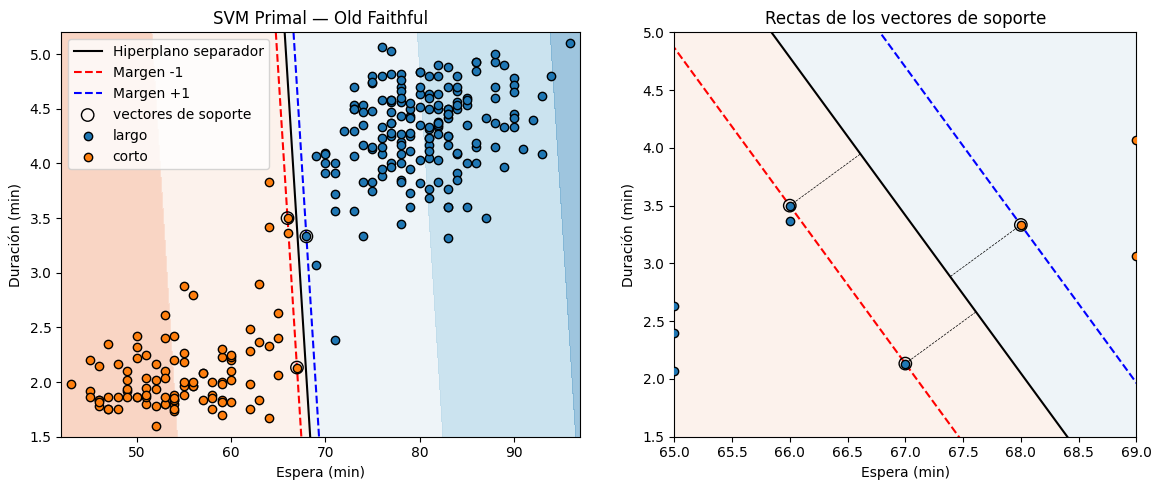

In [ ]:
# Entrenamiento
svm = LinearSVMPrimal()
svm.fit(X, y)

plot_svm_decision_boundary(svm, X, y, title="SVM Primal — Old Faithful")

# (c) Problema dual

El problema primal en SVM busca encontrar la mejor separación entre clases maximizando el margen, lo que implica minimiar la norma del vector de pesos $\mathbf{w}$ sujeto a restricciones de clasificación. Resolver este problema directamente puede ser complejo. Por ello, muchos modelos lineales para regresión y clasificación, incluyendo las SVMs, pueden reformularse en términos de una **representación dual**.

La formulación dual del problema de optimización de las SVMs se deriva utilizando multiplicadores de Lagrange y las condiciones de Karush-Kuhn-Tucker (KKT). Este problema dual suele ser un problema de **optimización cuadrática**. Una propiedad importante del problema dual es que su función objetivo es **cuadrática y convexa**, lo que garantiza que cualquier solución local encontrada es también un óptimo global.

Para resolver la formulación del problema dual se comienza definiendo el Lagrangiano generalizado:

$$\mathcal{L}(\mathbf{w}, b, \mathbf{\alpha})=\frac{1}{2}\lVert\mathbf{w}\rVert^2 - \sum_{i=1}^n\alpha_i\left[y_i(\mathbf{w}^T\mathbf{x}_i+b)-1\right]$$

Notar que hay solamente "$\alpha_i$" dado que el problema tiene solamente restricciones de desigualdad.


Se necesita en primer lugar minimizar $\mathcal{L}(\mathbf{w},b,\alpha)$ con respecto a $\mathbf{w}$ y $b$ (para un $\alpha$ fijo), lo cual se hace igualando a cero las derivadas de $\mathcal{L}$ con respecto a $\mathbf{w}$ y $b$:
$$\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w},b,\alpha)=\mathbf{w}-\sum_{i=1}^n\alpha_iy_i\mathbf{x}_i=\mathbf{0}$$
Esto implica que:
$$\mathbf{w}=\sum_{i=1}^n\alpha_iy_i\mathbf{x}_i$$
Derivando con respecto a $b$ se obtiene:
$$\frac{\partial}{\partial b}\mathcal{L}(\mathbf{w},b,\alpha)=\sum_{i=1}^n\alpha_iy_i=0$$
Insertando estas expresiones en el Lagrangiano:
\begin{align*}
\mathcal{L}(\mathbf{w},b,\alpha)&=\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j\mathbf{x}_i^T\mathbf{x}_j-b\underbrace{\sum_{i=1}^n\alpha_iy_i}_{=0}\\
&=\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j\mathbf{x}_i^T\mathbf{x}_j
\end{align*}

Combinando todo esto con las restricciones $\alpha_i\geq 0$ y $\sum_{i=1}^n\alpha_iy_i=0$ se obtiene el problema de optimización dual:
- **Maximizar**:
$W(\alpha)=\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j\mathbf{x}_i^T\mathbf{x}_j$
- **Sujeto a**: $\alpha_i\geq 0$ para $i=1,\dots,n$ y $\sum_{i=1}^n \alpha_iy_i=0$

Se puede verificar que las condiciones requeridas para que el problema primal y el dual sean iguales y las condiciones de Karush-Kuhn-Tucker (KKT), por lo tanto, se puede resolver el problema dual en lugar del problema primal.







Como en el caso anterior, se debe expresar la función objetivo y las restricciones del problema QP en formato estándar para poder utlizar $\texttt{solve_qp}$.

**Matriz cuadrática** $P$

Para encontrar la matriz cuadrática $P$ se define en primer lugar la matriz de productos vectoriales de las muestras $K_{i,j}=\mathbf{x}_i^T\mathbf{x}_j$:
$$K=\mathbf{X}\mathbf{X}^T\in\mathbb{R}^{n\times n}$$
y el producto de etiquetas $Y_{i,j}=y_iy_j$:
$$Y=\mathbf{y}\,\mathbf{y}^T$$

El elemento $i,j$ de $P$ debe coincidir con $y_iy_j\mathbf{x}_i^T\mathbf{x}_j$; por lo tanto:
$$P=Y\circ K\in \mathbb{R}^{n\times n}$$
donde $\circ$ es el producto elemento a elemento.

**Vector lineal** $q$

El único término lineal en el objetivo es $-\sum_{i}\alpha_i$, así que:
$$q=-\mathbf{1}\in\mathbb{R}^n$$

**Restricciones de desigualdad** $\alpha_i\geq 0$

Multiplicando ambos lados por ($-1$) se obtiene $-\alpha_i\leq 0$, luego:
$$G=-\mathbf{I}\in\mathbb{R^{n\times n}},\;\;\;\;\;\;h=\mathbf{0}\in\mathbb{R}^n$$

**Restricciones de igualdad** $\sum_i\alpha_iy_i=0$

Se representa con:
$$A=\mathbf{y}^T\in\mathbb{R}^{1\times n},\;\;\;\;\;\;b=0\in\mathbb{R}$$

**Hiperplano una vez resuelto**

Si $\alpha^\ast$ es la solución óptima:
$$\mathbf{w}^\ast=\sum_{i=1}^n \alpha^\ast y_i \mathbf{x}_i=(\alpha^\ast \circ \mathbf{y})^TX$$
y, tomando cualquier vector soporte $s$ con $\alpha_s^\ast>0$, o promediando varios,
$$b^\ast=y_s-\mathbf{w}^T\mathbf{x}_s=\frac{1}{|\mathcal{S}|}\sum_{i\in\mathcal{S}}(y_i-\mathbf{w}^T\mathbf{x}_i),\;\;\;\mathcal{S}=\{i: \alpha^\ast_i>0\}$$

In [ ]:
class LinearSVMDual:
    """
    SVM lineal (hard-margin) resuelto en el dual.
    Atributos:
        coef_            : ndarray (1, d)
        intercept_       : float
        support_vectors_ : ndarray (n_sv, d)
    """
    def __init__(self, tol=1e-6):
        self.coef_, self.intercept_ = None, None
        self.tol = tol
        support_vectors_ = None

    # Entrenamiento
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, d = X.shape

        # Matrices del QP dual
        K = X @ X.T
        P = (y[:, None] * y[None, :]) * K
        q = -np.ones(n)
        G = -np.eye(n)
        h = np.zeros(n)
        A = y.reshape(1, -1)
        b_eq = np.zeros(1)

        alpha = solve_qp(P, q, G, h, A, b_eq, solver="cvxopt")
        if alpha is None:
            raise ValueError("El problema dual no pudo resolverse.")

        # Hiperplano
        self.coef_ = (alpha * y) @ X
        sv_mask = alpha > self.tol
        self.intercept_  = np.mean(y[sv_mask] - X[sv_mask] @ self.coef_)
        self.support_vectors_ = X[sv_mask]

        return self


    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.coef_.ravel() + self.intercept_
        return scores

    def predict(self, X):
        return np.sign(self.decision_function(X))

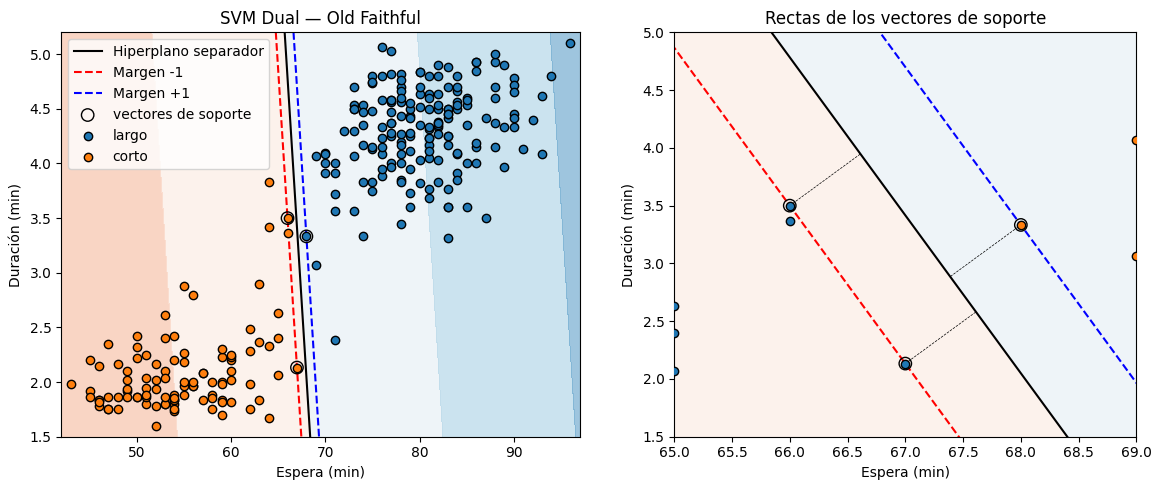

In [ ]:
# Entrenar
dual_svm = LinearSVMDual().fit(X, y)

plot_svm_decision_boundary(dual_svm, X, y, title="SVM Dual — Old Faithful")


# (d) Problema primal con márgenes relajados

Para que el algoritmo funciones con conjuntos de datos no linealmente separables (en este caso lo es) y sea menos sensible a valores atípicos, se reformula la optimización (utilizando la regularización $\ell_1$) de la siguiente manera:
- **Minimizar**:
$\min_{\gamma, \mathbf{w},b}\frac{1}{2}\lVert\mathbf{w}\rVert^2+C\sum_{i=1}^n\xi_i$
- **Sujeto a**: $y_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1-\xi_i$ y $\xi_i\geq 0,\;\;\;i=1,\dots,n$

Esto permite márgenes menores que 1, y si se tiene un margen $1-\xi_i$ (con $\xi_i>0$), se paga un costo por el incremento de la función objetivo de $C\xi_i$. Entonces, el parámetro $C$ contral la ponderación relativa entre los objetivos de minimizar $\lVert\mathbf{w}\rVert^2$ (que hace que el margen sea grande) y asegurar que la mayoría de las muestran tengan un margen de al menos 1.



Para su implementación, se debe expresar la función objetivo y las restricciones del problema QP en formato estándar para poder utlizar $\texttt{solve_qp}$.

**Vector de incógnitas**

$$\mathbf{z}=\begin{bmatrix}\mathbf{w}\\b\\\boldsymbol{\xi}\end{bmatrix}\in \mathbb{R}^{d+1+n}$$

**Matriz cuadrática** $P$

Sólo penaliza lar norma de $\mathbf{w}$

$$P=\begin{bmatrix}\mathbf{I}_d & \mathbf{0}_{d\times 1}& \mathbf{0}_{d\times n}\\
\mathbf{0}_{1\times d}& 0 & \mathbf{0}_{1\times n}\\ \mathbf{0}_{n\times d}& \mathbf{0}_{n\times 1}& \mathbf{0}_{n\times n}\end{bmatrix}\in\mathbb{R}^{(d+1+n)\times (d+1+n)}$$

**Vector lineal** $q$
$$q=\begin{bmatrix}\mathbf{0}_{d+1}\\ C\, \mathbf{1}_n\end{bmatrix}\in\mathbb{R}^{d+1+n}$$

**Desigualdades** $Gz\leq h$

Las restricciones de margen desplazado son:
$$-y_i\mathbf{x}_i\mathbf{w}-y_ib-\xi_i\leq -1$$
Entonces, la fila $i$ de $G$ y de $h$ son:

$$G_i^{(1)}=\begin{bmatrix}-y_i\mathbf{x}^T_i & -y_i & -\boldsymbol{e}_i^T\end{bmatrix}\;\;\; h_i^{(1)}=-1$$
donde $\mathbf{e}_i$ es el i-ésimo vector canónico de $\mathbb{R}^n$.

No negatividad de relajación
$$-\xi_i\leq 0$$

Luego la final $n+i$ es:

$$G_i^{(2)}=\begin{bmatrix}\mathbf{0}_{1\times (d+1)} & -\mathbf{e}_i^T\end{bmatrix}\;\;\; h_i^{(2)}=0$$

En forma completa:

$$G=\begin{bmatrix}-y_1\mathbf{x}_1^T & -y_1 & -\mathbf{e}_1^T\\
\vdots & \vdots & \vdots \\
-y_n\mathbf{x}_n^T & -y_n & -\mathbf{e}_n^T\\
\mathbf{0}_{n\times d} & \mathbf{0}_{n} & -\mathbf{I}_n
\end{bmatrix}\in\mathbb{R}^{(2n)\times (d+1+n)}\;\;\;h=\begin{bmatrix}-1\\
\vdots \\-1\\0\\ \vdots \\ 0 \end{bmatrix}\in\mathbb{R}^{2n}$$

**Igualdades**

No hay igualdades distintas de fijar $b$

$$A=\mathbf{0}_{1\times (d+1+n)}\;\;\; b=0$$

(en `solve_qp` se pasa `A=None`, `b=None`)












In [ ]:
class SoftMarginSVMPrimal:
    """
    SVM lineal (margen suave) resuelto en el primal.
    Atributos:
        coef_            : ndarray (1, d)
        intercept_       : float
        support_vectors_ : ndarray (n_sv, d)
        tol              : float
    """
    def __init__(self, C=1.0, tol=1e-6):
        self.C   = C
        self.coef_, self.intercept_ = None, None
        self.tol = tol
        support_vectors_ = None

    # Entrenamiento
    def fit(self, X, y):
        X = np.asarray(X, float)
        y = np.asarray(y, float)
        n, d = X.shape

        # Matrices del QP
        P = np.zeros((d + 1 + n, d + 1 + n))
        P[:d, :d] = np.eye(d)

        q = np.hstack([np.zeros(d + 1), self.C * np.ones(n)])

        # Margen desplazado
        G1 = np.hstack([-y[:, None] * X,
                        -y[:, None],
                        -np.eye(n)])
        h1 = -np.ones(n)

        # Holguras
        G2 = np.hstack([np.zeros((n, d + 1)), -np.eye(n)])
        h2 = np.zeros(n)

        G = np.vstack([G1, G2])
        h = np.hstack([h1, h2])

        # Resolución
        sol = solve_qp(P, q, G, h, solver="cvxopt", tol=1e-10)
        if sol is None:
            raise ValueError("QP no resoluble")

        self.coef_      = sol[:d]
        self.intercept_ = float(sol[d])
        self.xi         = sol[d + 1:]

        margins = y * (X @ self.coef_.ravel() + self.intercept_)
        self.support_vectors_ = X[margins < 1 + self.tol]

        return self

    def decision_function(self, X):
        X = np.asarray(X, float)
        return X @ self.coef_.ravel() + self.intercept_

    def predict(self, X):
        return np.sign(self.decision_function(X))

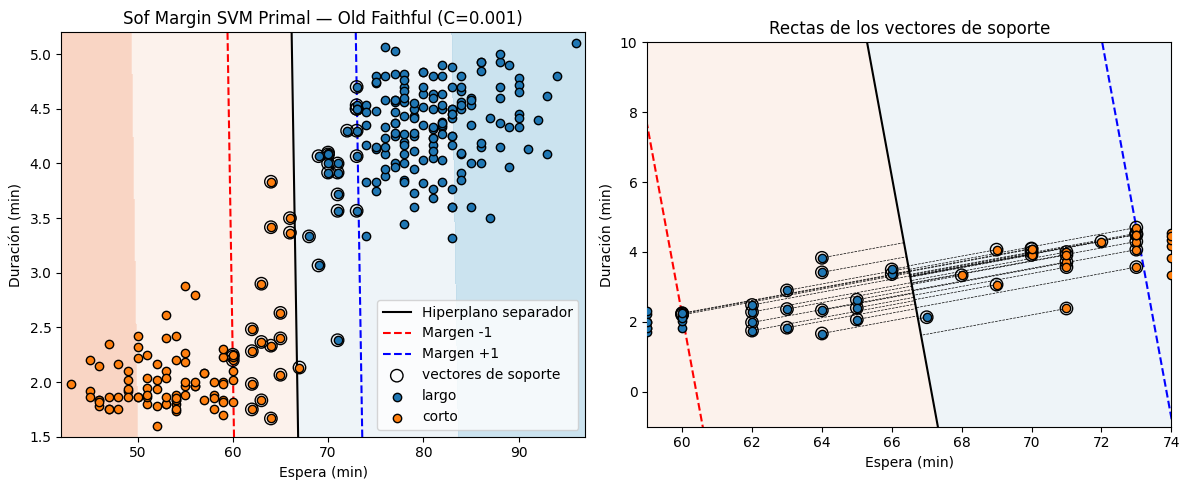

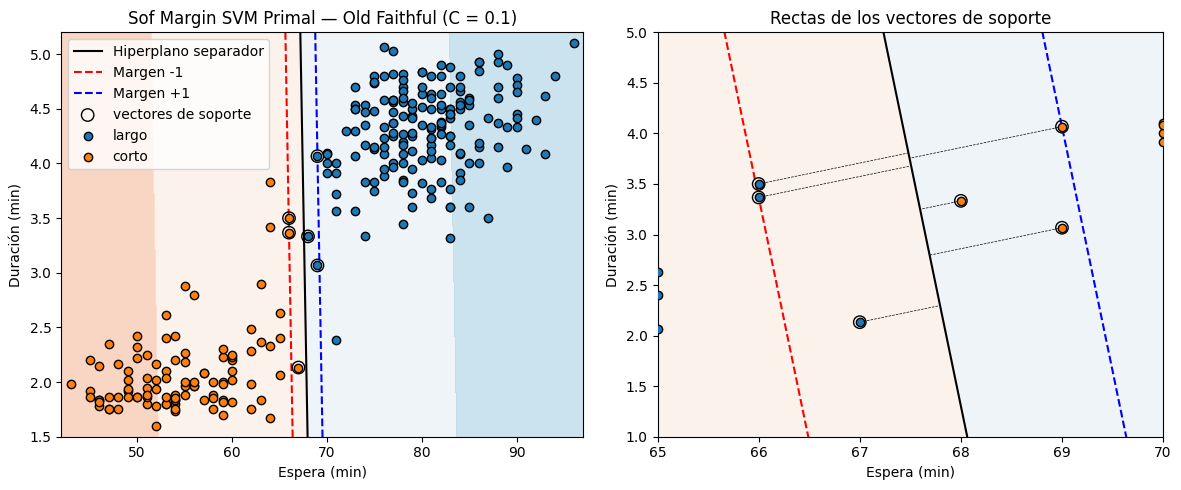

In [ ]:
# Entrenar
soft_primal_svm_1 = SoftMarginSVMPrimal(C=0.001).fit(X, y)
soft_primal_svm_2 = SoftMarginSVMPrimal(C=0.1).fit(X, y)

plot_svm_decision_boundary(soft_primal_svm_1, X, y, title="Sof Margin SVM Primal — Old Faithful (C=0.001)", xmin = 59, xmax = 74, ymin=-1, ymax=10)

plot_svm_decision_boundary(soft_primal_svm_2, X, y, title="Sof Margin SVM Primal — Old Faithful (C = 0.1)", xmin = 65, xmax = 70, ymin=1, ymax=5)


# (e) Problema dual con márgenes relajados

Como antes se plantea el Lagrangiano:

$$\mathcal{L}(\mathbf{w},b,\xi,\alpha,r)=\frac{1}{2}\mathbf{w}^T\mathbf{w}+C\sum_{i=1}^n\xi_i-\sum_{i=1}^n\alpha_i\left[y_i(\mathbf{x}^T\mathbf{w}+b)-1+\xi_i\right]-\sum_{i=1}^nr_i\xi_i$$
Aquí, las $\alpha_i$ y $r_i$ son los multiplicadores de Lagrange (restringidos a ser $\geq 0$)



Como antes, se establecene las derivadas con respecto a $\mathbf{w}$, $b$ y $\xi$ en cero
\begin{aligned}
\frac{\partial\mathcal L}{\partial\mathbf w}=0
&\;\Longrightarrow\;
\mathbf w=\sum_{i=1}^{n}\alpha_i y_i\mathbf x_i,\\[6pt]
\frac{\partial\mathcal L}{\partial b}=0
&\;\Longrightarrow\;
\sum_{i=1}^{n}\alpha_i y_i = 0,\\[6pt]
\frac{\partial\mathcal L}{\partial\xi_i}=0
&\;\Longrightarrow\;
C-\alpha_i-r_i = 0
\;\Longrightarrow\;
0\le\alpha_i\le C.
\end{aligned}
Con $r_i\ge0$ resulta inmediatamente $0\le\alpha_i\le C$.

Se sustituye $\mathbf w$ y se usa la igualdad sobre $b$:
1. Norma de $\mathbf{w}$
$$\frac{1}{2}\mathbf{w}^T\mathbf{w}=\frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy_iy_j\mathbf{x}_i^T\mathbf{x}_j$$
2. Término con $b$
$$-b\sum_i\alpha_iy_i=0$$
3. Términos con $\xi_i$
$$C\sum_i\xi_i-\sum_i\alpha_i\xi_i-\sum_ir_i\xi_i=C\sum_i\xi_i-\sum_i\alpha_i\xi_i-\sum_i(C-\alpha_i)\xi_i=0$$

De esta forma $\boldsymbol\xi$ y $\mathbf r$ desaparecen por completo.

La función de Lagrange reducida queda:

$$\mathcal{L}(\alpha)=\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n\alpha_i\alpha_jy_iy_j\mathbf{x}_i^T\mathbf{x}_j$$

Maximizar la expresión anterior bajo las restricciones encontradas es exactamente la forma dual del problema:

- **Maximizar**:
$$\max_\alpha W(\alpha)=\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^ny_iy_j\alpha_i\alpha_j\mathbf{x}_i^T\mathbf{x}_j$$
- **Sujeto a**: $0\leq \alpha_i\leq C,\;\;\;i=1,\dots,n$ y $\sum_{i=1}^n\alpha_iy_i=0$

# (f) Implementación del problema dual suave

Como en los casos anteriores, se debe expresar la función objetivo y las restricciones del problema QP en formato estándar para poder utlizar $\texttt{solve_qp}$.

**Matriz cuadrática** $P$
  
Para encontrar la matriz cuadrática $P$ se define en primer lugar la matriz de productos vectoriales de las muestras $K_{i,j}=\mathbf{x}_i^T\mathbf{x}_j$:
$$K=\mathbf{X}\mathbf{X}^T\in\mathbb{R}^{n\times n}$$
y el producto de etiquetas $Y_{i,j}=y_iy_j$:
$$Y=\mathbf{y}\,\mathbf{y}^T$$

El elemento $i,j$ de $P$ debe coincidir con $y_iy_j\mathbf{x}_i^T\mathbf{x}_j$; por lo tanto:
$$P=Y\circ K\in \mathbb{R}^{n\times n}$$
donde $\circ$ es el producto elemento a elemento.

**Vector lienal** $q$

El único término lineal en el objetivo es $-\sum_{i}\alpha_i$, así que:
$$q=-\mathbf{1}\in\mathbb{R}^n$$

**Desigualdades** $G\alpha\leq h$

- $\alpha_i\geq 0\Rightarrow -\alpha_i\leq 0$
- $\alpha_i\leq C\Rightarrow -\alpha_i\leq C$

Por lo tanto:
$$G=\begin{bmatrix}-\mathbf{I}_n\\\mathbf{I}_n\end{bmatrix}\in \mathbb{R}^{2n\times n},\;\;\;h=\begin{bmatrix}\mathbf{0}_n\\C\,\mathbf{1}_n\end{bmatrix}\in\mathbb{R}^{2n}$$

**Igualdad** $A\alpha=b$
$$\sum_{i=1}^n\alpha_iy_i=0\Rightarrow A=\mathbf{y}^T\in\mathbb{R}^{1\times n},\;\;\;b=0$$

In [ ]:
class SoftMarginSVMDual:
    """
    SVM lineal (margen suave) resuelto en el dual.
    Atributos públicos: coef_, intercept_, support_vectors_.
    """
    def __init__(self, C=1.0, tol=1e-6):
        self.C = C
        self.coef_, self.intercept_ = None, None
        self.tol = tol
        support_vectors_ = None

    # Entrenamiento
    def fit(self, X, y):
        X = np.asarray(X, float)
        y = np.asarray(y, float)
        n, d = X.shape

        # Matriz Q
        K = X @ X.T
        P = (y[:, None] * y[None, :]) * K      # (n,n)
        q = -np.ones(n)

        # G y h
        G = np.vstack([ -np.eye(n),  np.eye(n) ])
        h = np.hstack([ np.zeros(n),  self.C*np.ones(n) ])

        # Igualdad
        A = y.reshape(1, -1)
        b_eq = np.zeros(1)

        alpha = solve_qp(P, q, G, h, A, b_eq, solver="cvxopt", eps_abs=1e-10)
        if alpha is None:
            raise ValueError("El QP dual no se pudo resolver.")

        # hiperplano
        self.coef_ = (alpha * y) @ X
        sv_mask = alpha > self.tol
        self.support_vectors_ = X[sv_mask]
        self.intercept_ = np.mean(y[sv_mask] - X[sv_mask] @ self.coef_.ravel())
        self.alpha = alpha
        return self

    def decision_function(self, X):
        X = np.asarray(X, float)
        return X @ self.coef_.ravel() + self.intercept_

    def predict(self, X):
        return np.sign(self.decision_function(X))


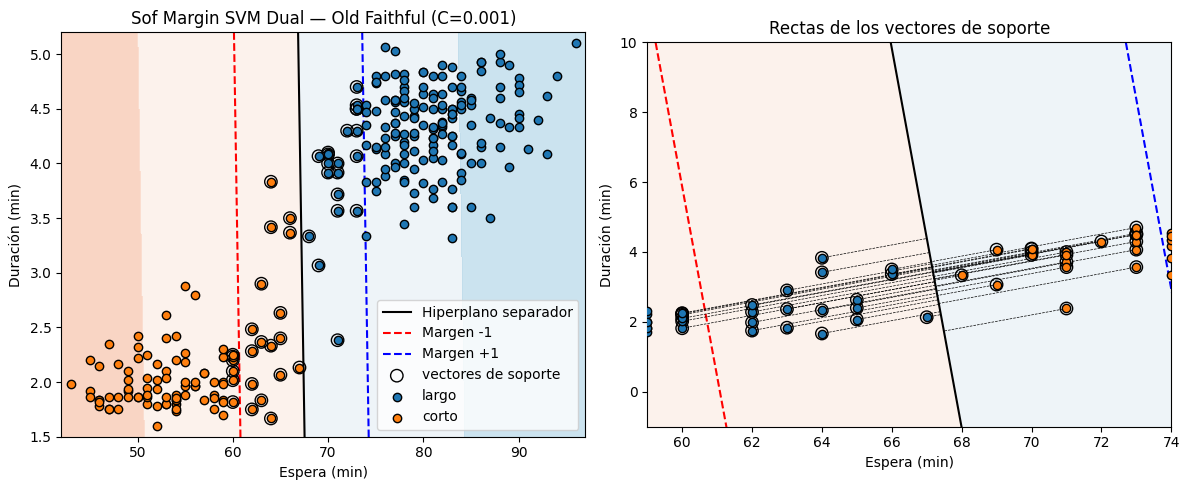

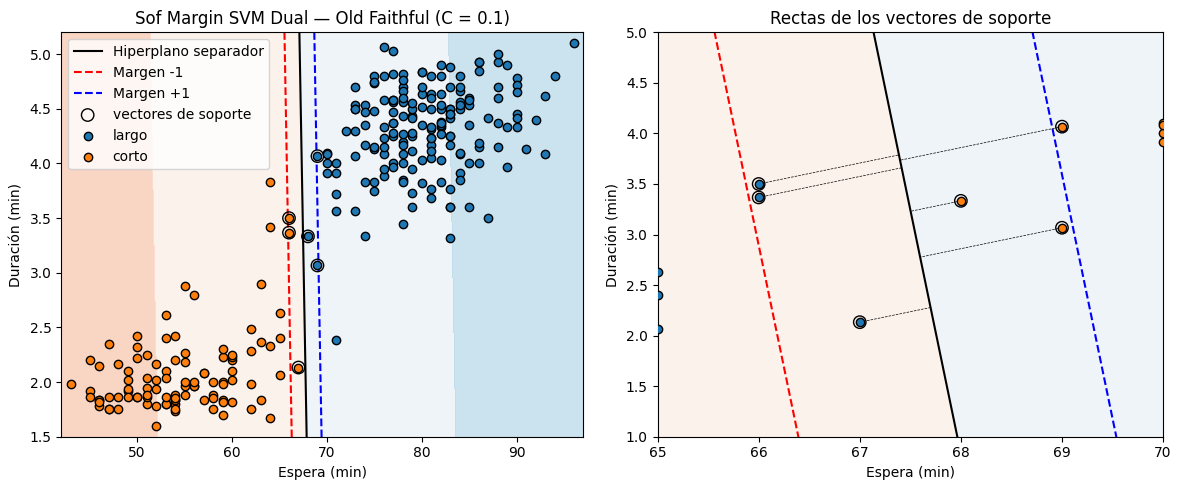

In [ ]:
# Entrenar
soft_dual_svm_1 = SoftMarginSVMDual(C=0.001, tol=1e-10).fit(X, y)
soft_dual_svm_2 = SoftMarginSVMDual(C=0.1, tol=1e-10).fit(X, y)

plot_svm_decision_boundary(soft_dual_svm_1, X, y, title="Sof Margin SVM Dual — Old Faithful (C=0.001)", xmin = 59, xmax = 74, ymin=-1, ymax=10)
plot_svm_decision_boundary(soft_dual_svm_2, X, y, title="Sof Margin SVM Dual — Old Faithful (C = 0.1)", xmin = 65, xmax = 70, ymin=1, ymax=5)


# (g) Conclusiones.

A continuación, se muestran en conjunto todos los gráficos desarrollados para los distintos métodos. Éstos permiten ver cómo cambia el comportamiento del clasificador en los casos de margen duro y margen blando, y, dentro de este último, cómo influye el valor de $C$.

En la primera fila se grafican los **casos duros**, primal y dual. Ambos producen exactamente la misma frontera. El **margen es el más angosto posible**, porque los modelos no admiten relajación de éstos. El hecho de que las soluciones **primal y dual coincidan** confirma la equivalencia teórica entre ambas formulaciones.

En la segunda fila se grafican los casos para un valor de $C$ **relativamente bajo**. Al **penalizar muy poco las violaciones**, el margen se ensancha, muchos puntos caen dentro de éste o incluso del lado equivocado. Es decir, con un $C$ pequeño se sacrifica precisión para ganar simplicidad.

Adicionalmente, se observa una diferencia entre ambos márgenes (aunque con los mismos vectores soporte), que puede estar dada por cuestiones de precisión numérica o algún error en la implementación.

En la tercera fila se grafican los casos para un valor de $C$ **relativamente más alto**. Es decir, la penalización por error es mayor, de modo que el clasificador **vuelve a acercarse a la solución dura**. Como es de esperase, el margen se estrecha, la recta tiene la inclinación del problema original y los errores se reducen.


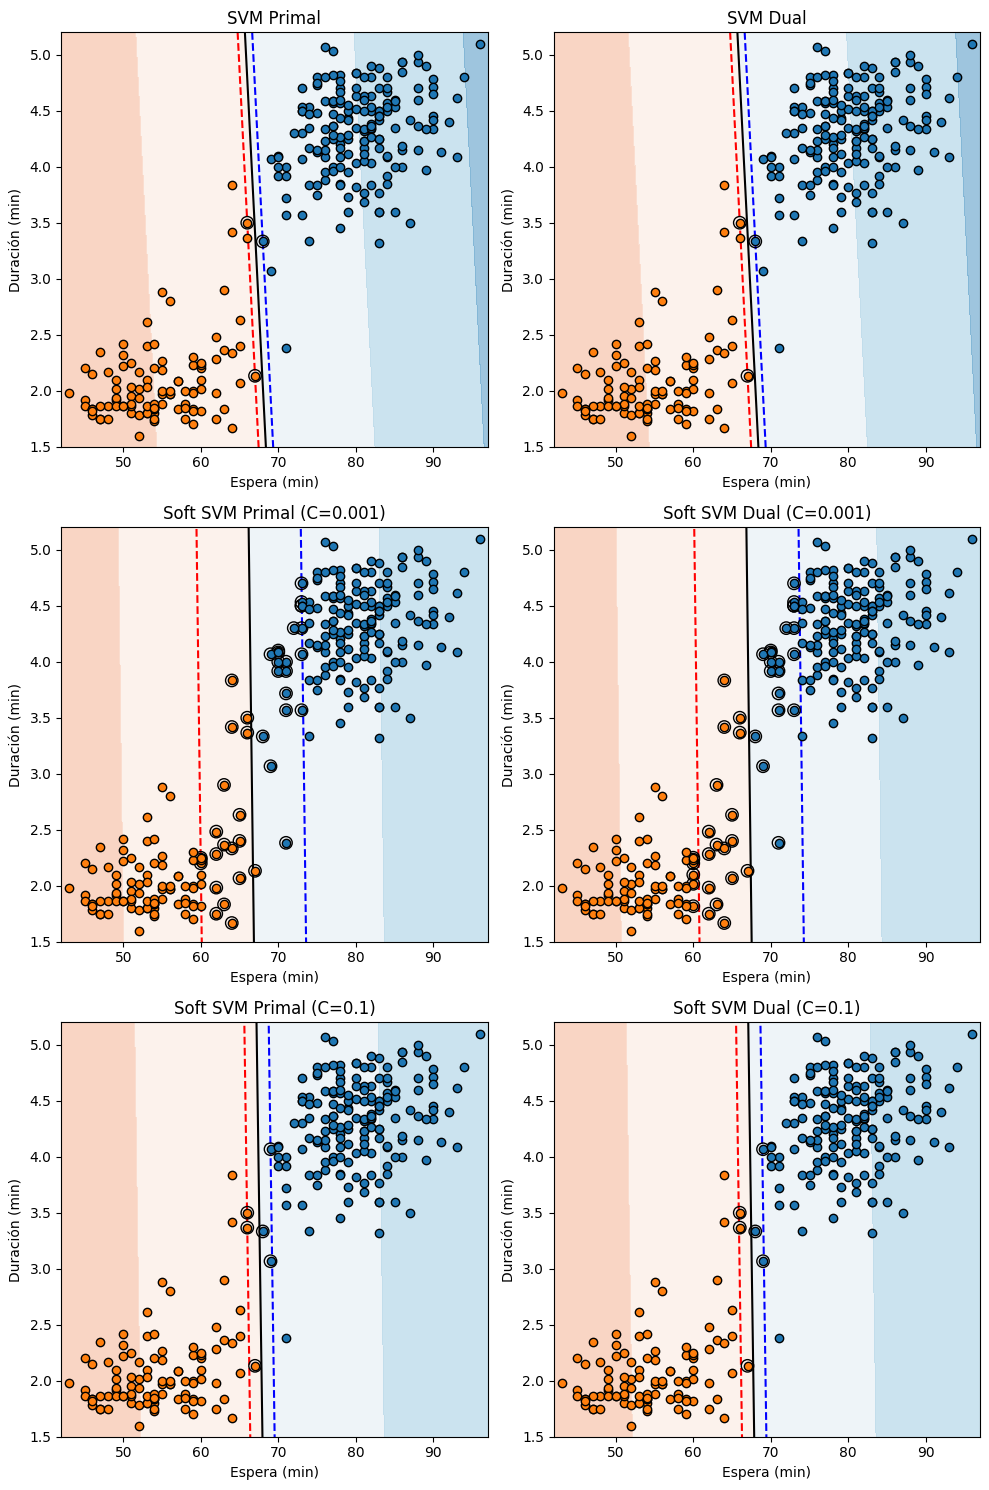

In [ ]:
def plot_svm_subplot(svm, X, y, ax, title, xmin=None, xmax=None, ymin=None, ymax=None):

    w = svm.coef_
    slope = -w[0] / w[1]
    x_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 2000)
    decision_boundary = slope * x_range - (svm.intercept_) / w[1]


    margin = 1 / np.sqrt(np.sum(svm.coef_**2))
    margin_down = decision_boundary - np.sqrt(1 + slope**2) * margin
    margin_up = decision_boundary + np.sqrt(1 + slope**2) * margin


    ax.plot(x_range, decision_boundary, "k-", label="Hiperplano separador")
    ax.plot(x_range, margin_down, "r--", label="Margen -1")
    ax.plot(x_range, margin_up, "b--", label="Margen +1")

    ax.scatter(
        svm.support_vectors_[:, 0],
        svm.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        label="vectores de soporte"
    )
    ax.scatter(X[y == 1, 0], X[y == 1, 1], zorder=10, edgecolors="k", label="largo")
    ax.scatter(X[y == -1, 0], X[y == -1, 1], zorder=10, edgecolors="k", label="corto")


    YY, XX = np.meshgrid(decision_boundary, x_range)
    xy = np.c_[XX.ravel(), YY.ravel()]
    Z = svm.decision_function(xy).reshape(XX.shape)
    ax.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])


    ax.set_ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    if xmin is not None and xmax is not None:
        ax.set_xlim(xmin, xmax)
    if ymin is not None and ymax is not None:
        ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Espera (min)")
    ax.set_ylabel("Duración (min)")
    ax.set_title(title)


plt.figure(figsize=(10, 15))

models = [
    (svm, "SVM Primal"),
    (dual_svm, "SVM Dual"),
    (soft_primal_svm_1, "Soft SVM Primal (C=0.001)"),
    (soft_dual_svm_1, "Soft SVM Dual (C=0.001)"),
    (soft_primal_svm_2, "Soft SVM Primal (C=0.1)"),
    (soft_dual_svm_2, "Soft SVM Dual (C=0.1)")
]

for i, (model, title, *limits) in enumerate(models):
    ax = plt.subplot(3, 2, i + 1)
    plot_svm_subplot(model, X, y, ax, title, *limits)

plt.tight_layout()
plt.show()